In [27]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

import pickle

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import merge, Input
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D

from keras.models import Model
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [28]:
def change_labels(labels):
    new_labels = []
    for elem in labels:
        if elem == 0:
            new_labels.append('bee')
        elif elem == 1:
            new_labels.append('insect')
        elif elem == 2:
            new_labels.append('other')
        elif elem == 3:
            new_labels.append('wasp')
        
    return new_labels           

In [29]:
def change_labels_tonum(label):
    if label == 'bee':
        new_label = 0
    elif label == 'insect':
        new_label = 1
    elif label == 'other':
        new_label = 2
    elif label == 'wasp':
        new_label = 3
        
    return new_label   

In [30]:
model_last1 = load_model('last_layer_trained_model.h5')
model_last2 = load_model('last_2_layers_trained_model.h5')
model_full = load_model('full_trained_model.h5')
model_removed = load_model('full_trained_model_removed_layers.h5')
model_1 = load_model('classifiaction_layer_trained_model')


In [31]:
train_dir = "kaggle_bee_vs_wasp/"
resize_size = 224
bees_vs_wasps_dataset_path=Path(train_dir)

In [32]:
training_subsample = 0.1
#insect_class = {'bee': 0,'wasp': 1, 'insect': 2,'other': 3} 

df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels = df_labels.set_index('id')
df_labels = df_labels.sample(frac=training_subsample, axis=0)
df_labels = df_labels[['path','label']]
df_labels = df_labels.reset_index(drop=True)
df_labels

,path,label
0,wasp2\W00201.jpg,wasp
1,wasp1\49493935647_450b578cda_n.jpg,wasp
2,other_insect\8997829093_8b44e0e3db_w.jpg,insect
3,other_insect\5717391706_b7e7f2a364_n.jpg,insect
4,bee2\P23937-121r.jpg,bee
...,...,...
2393,other_insect\4137219472_0572a9e7b6_n.jpg,insect
2394,bee1\34980605612_66e6b12b4a_m.jpg,bee
2395,other_insect\4789767506_05004e34b2_n.jpg,insect
2396,other_noinsect\578776.jpg,other


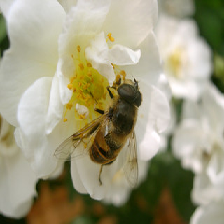

In [33]:
sample = df_labels.sample()
image_path = sample.path
image_path = image_path.replace('\\','/')
image = load_img(train_dir + image_path.values[0], target_size=(resize_size, resize_size))
image

In [34]:
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
predictions = model_full.predict(image)

print(predictions)
predicted_class = np.argmax(predictions)
print(predicted_class)
print(sample.label)

[[6.5154432e-24 1.0000000e+00 0.0000000e+00 5.7717096e-14]]
1
2108    bee
Name: label, dtype: object


##  Last layer trained 

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_last1.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 2398 validated image filenames belonging to 4 classes.
2398/2398 [==============================] - 238s 99ms/step


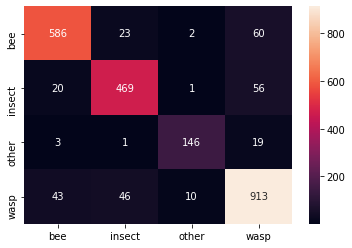

In [36]:
label_names = ['bee','insect','other','wasp']
matrix_last1 = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_last1, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Last 2 layers trained 

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_last2.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 2398 validated image filenames belonging to 4 classes.
2398/2398 [==============================] - 270s 113ms/step


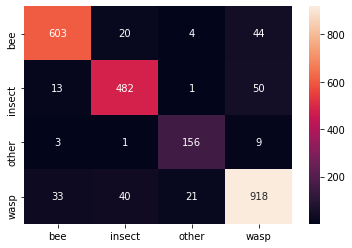

In [38]:
label_names = ['bee','insect','other','wasp']
matrix_last2 = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_last2, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Full trained model 

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_full.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 2398 validated image filenames belonging to 4 classes.
2398/2398 [==============================] - 266s 111ms/step


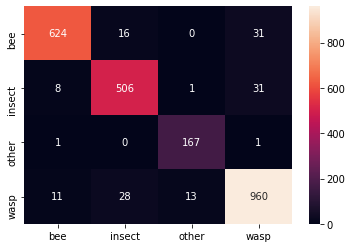

In [40]:
label_names = ['bee','insect','other','wasp']
matrix_full = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_full, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Full trained model removed layers 

In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_removed.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 2398 validated image filenames belonging to 4 classes.
2398/2398 [==============================] - 279s 116ms/step


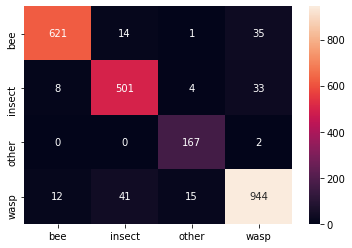

In [42]:
label_names = ['bee','insect','other','wasp']
matrix_removed = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_removed, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Only classificator trained 

In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_1.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 2398 validated image filenames belonging to 4 classes.
2398/2398 [==============================] - 258s 108ms/step


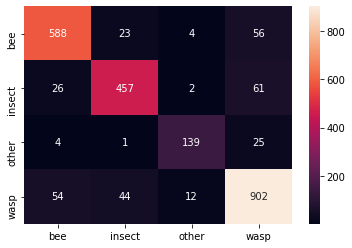

In [44]:
label_names = ['bee','insect','other','wasp']
matrix_1 = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_1, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## SVM 

In [45]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)

Found 2398 validated image filenames belonging to 4 classes.


In [46]:
image_input = Input(shape=(resize_size, resize_size, 3))
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
last_layer = model.get_layer('block5_pool')
last_output = last_layer.output
x = Flatten()(last_output)
custom_vgg_model = Model(image_input, x)
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
for layer in custom_vgg_model.layers:
    layer.trainable = False

In [47]:
features=custom_vgg_model.predict(test_generator, steps=len(df_labels), verbose=1)

2398/2398 [==============================] - 244s 102ms/step


0.8932443703085905

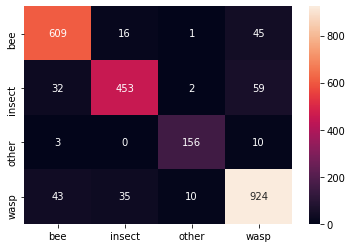

In [48]:

lin_model =  pickle.load(open("lin_svm.sav", 'rb'))
y_pred = lin_model.predict(features)
label_names = ['bee','insect','other','wasp']
matrix_lin = confusion_matrix(test_generator.labels, y_pred)
sns.heatmap(matrix_lin, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)
lin_score = accuracy_score(test_generator.labels, y_pred)
lin_score

0.8673894912427023

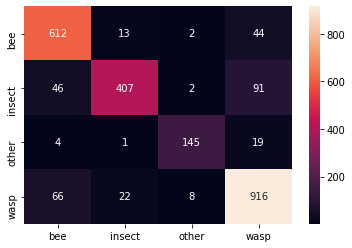

In [49]:
quadr_model =  pickle.load(open("quadratic_svm.sav", 'rb'))
y_pred = quadr_model.predict(features)
label_names = ['bee','insect','other','wasp']
matrix_lin = confusion_matrix(test_generator.labels, y_pred)
sns.heatmap(matrix_lin, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)
lin_score = accuracy_score(test_generator.labels, y_pred)
lin_score

0.8661384487072561

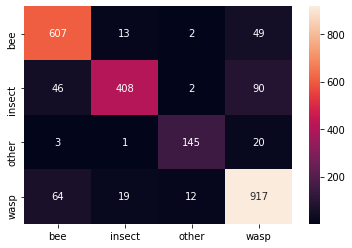

In [50]:
exp_model =  pickle.load(open("exp_svm.sav", 'rb'))
y_pred = exp_model.predict(features)
label_names = ['bee','insect','other','wasp']
matrix_lin = confusion_matrix(test_generator.labels, y_pred)
sns.heatmap(matrix_lin, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)
lin_score = accuracy_score(test_generator.labels, y_pred)
lin_score